###Install & Import Dependencies, Load Dataset

In [1]:
!pip -q install matplotlib seaborn wordcloud nltk scikit-learn tensorflow gensim plotly keras pandas numpy tokenizers torch transformers einops torchinfo x_transformers torcheval transformers[torch]
!pip -q install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 37.2 MB/s eta 0:00:00


In [2]:
!pip freeze > requirements_colab.txt

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import re
import string
from wordcloud import WordCloud
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

# import dill

from nltk.stem import PorterStemmer
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
import string
punctuations = list(string.punctuation)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, svm

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

#from scikitplot.metrics import plot_confusion_matrix, plot_roc

import tensorflow as tf

from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
import time
from keras.layers import Dense, Input, Flatten, LSTM, Bidirectional,Embedding, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Sequential, load_model
from keras import losses
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.preprocessing.sequence import pad_sequences
#from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from transformers import Trainer, AutoTokenizer, AutoModelForSequenceClassification

# Train a model from scratch -----------------------------------------------------
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer
from tokenizers import decoders
import torch
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
from transformers import DataCollatorForSeq2Seq
from transformers import PreTrainedTokenizerFast
from tokenizers.implementations import BaseTokenizer
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
from einops import rearrange, pack, unpack
from torchinfo import summary
import numpy
import random
from torcheval.metrics.functional.text import perplexity
from transformers import TrainingArguments, Trainer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
data = pd.read_csv('mental_health.csv')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/NLP_project/mental_health.csv'
data = pd.read_csv(file_path)
data.head()

In [6]:
data.isnull().sum()

text     0
label    0
dtype: int64

In [7]:
data['label'].value_counts()

label
0    14139
1    13838
Name: count, dtype: int64

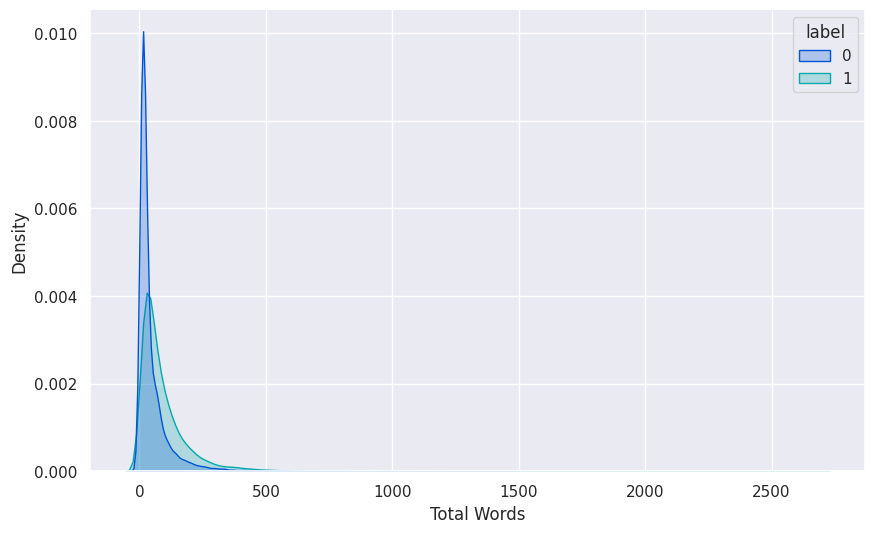

In [8]:
data['Total Words'] = data['text'].apply(lambda x: len(x.split()))

def count_total_words(text):
    char = 0
    for word in text.split():
        char += len(word)
    return char

data['Total Chars'] = data["text"].apply(count_total_words)
plt.figure(figsize = (10, 6))
sns.kdeplot(x = data['Total Words'], hue= data['label'], palette= 'winter', shade = True)
plt.show()

### Text Pre-processing

In [25]:
class TextPreprocessor:
    def __init__(self):
        self.re_url = re.compile(r'https?://\S+|www\.\S+')
        self.exclude_punc = str.maketrans('', '', string.punctuation)
        self.stopwrds =  list(stopwords.words('english'))
        self.stemmer = PorterStemmer()

    def remove_punctuation(self, text):
        return text.translate(self.exclude_punc)

    def remove_url(self, text):
        return self.re_url.sub('', text)

    def convert_lowercase(self, text):
        return text.lower()

    def remove_stopwords(self, text):
      new_list = []
      words = word_tokenize(text)
      for word in words:
          if word not in self.stopwrds:
              new_list.append(word)
      return ' '.join(new_list)

    def perform_stemming(self, text):
      new_list = []
      words = word_tokenize(text)
      for word in words:
          new_list.append(self.stemmer.stem(word))

      return " ".join(new_list)

    def preprocess(self, text):
        text = str(text)
        text = self.remove_url(text)
        text = self.remove_punctuation(text)
        text = self.convert_lowercase(text)
        text = self.remove_stopwords(text)
        text = self.perform_stemming(text)
        return text

    def apply(self, data, column_name):
        data[column_name] = data[column_name].apply(self.preprocess)
        return data

preprocessor = TextPreprocessor()

data = preprocessor.apply(data, 'text')


###Text Visualization

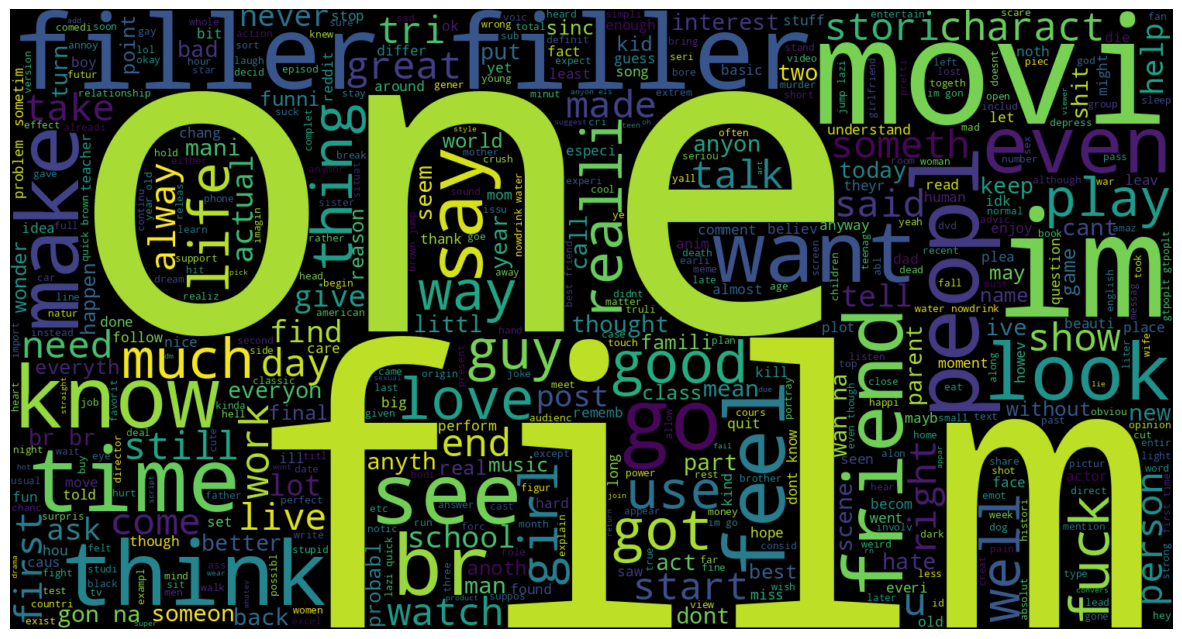

In [10]:
text = " ".join(data[data['label'] == 0]['text'])
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=500, height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

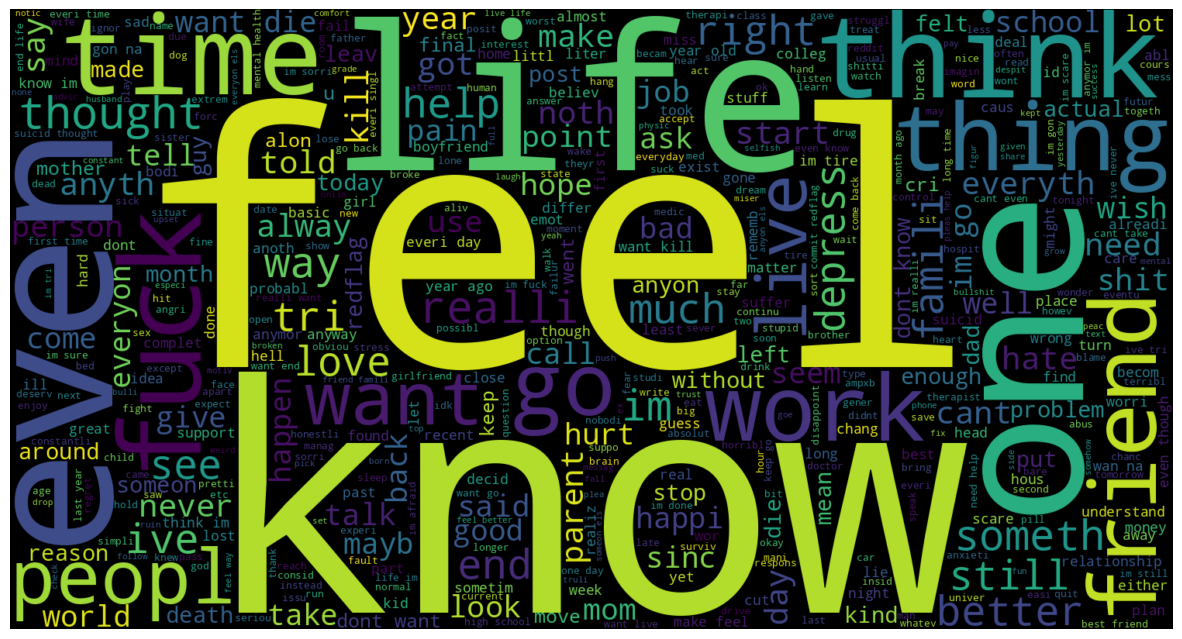

In [11]:
text = " ".join(data[data['label'] == 1]['text'])
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=500, height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

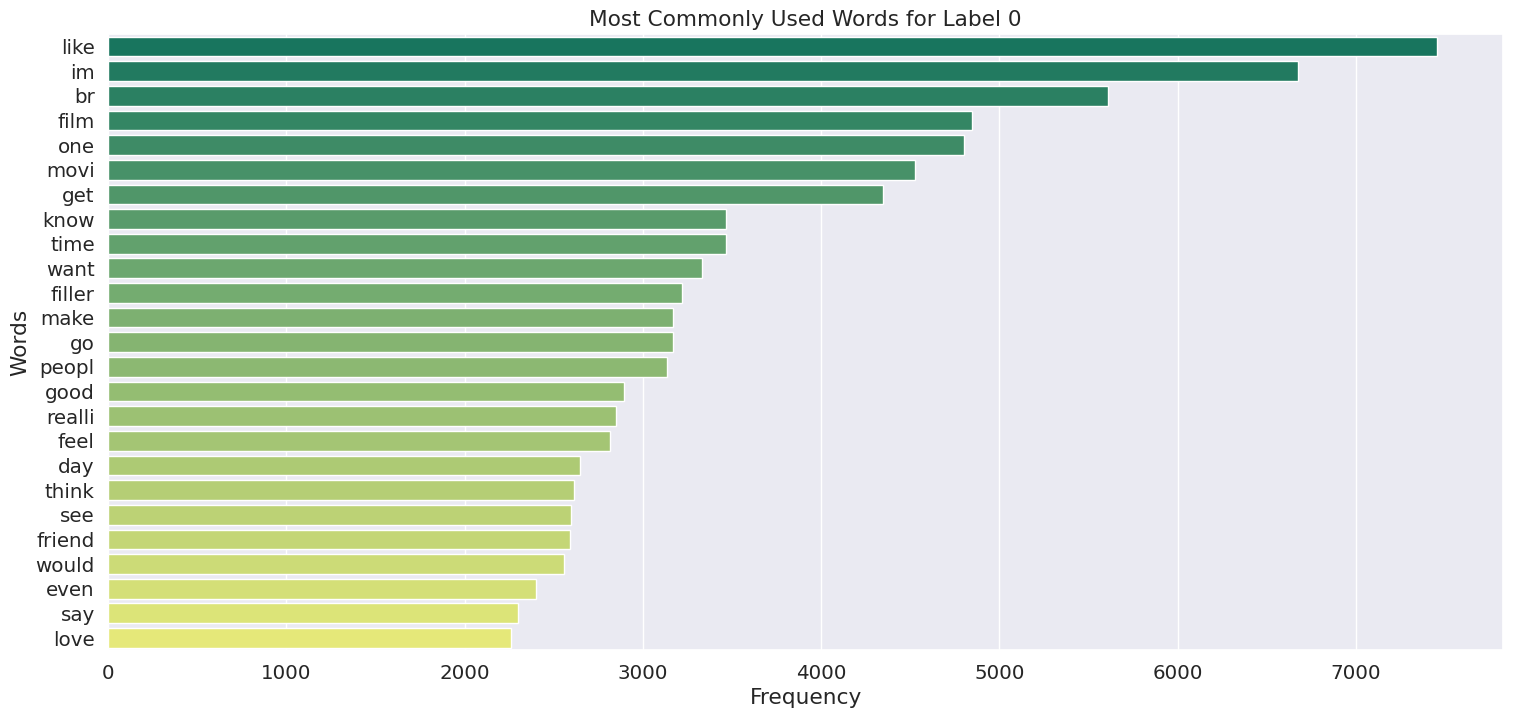

In [12]:
all_spam_words = []
for sentence in data[data['label'] == 0]['text'].to_list():
    for word in sentence.split():
        all_spam_words.append(word)

df = pd.DataFrame(Counter(all_spam_words).most_common(25), columns= ['Word', 'Frequency'])

sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(18,8))
sns.barplot(y = df['Word'], x= df['Frequency'], palette= 'summer')
plt.title("Most Commonly Used Words for Label 0")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

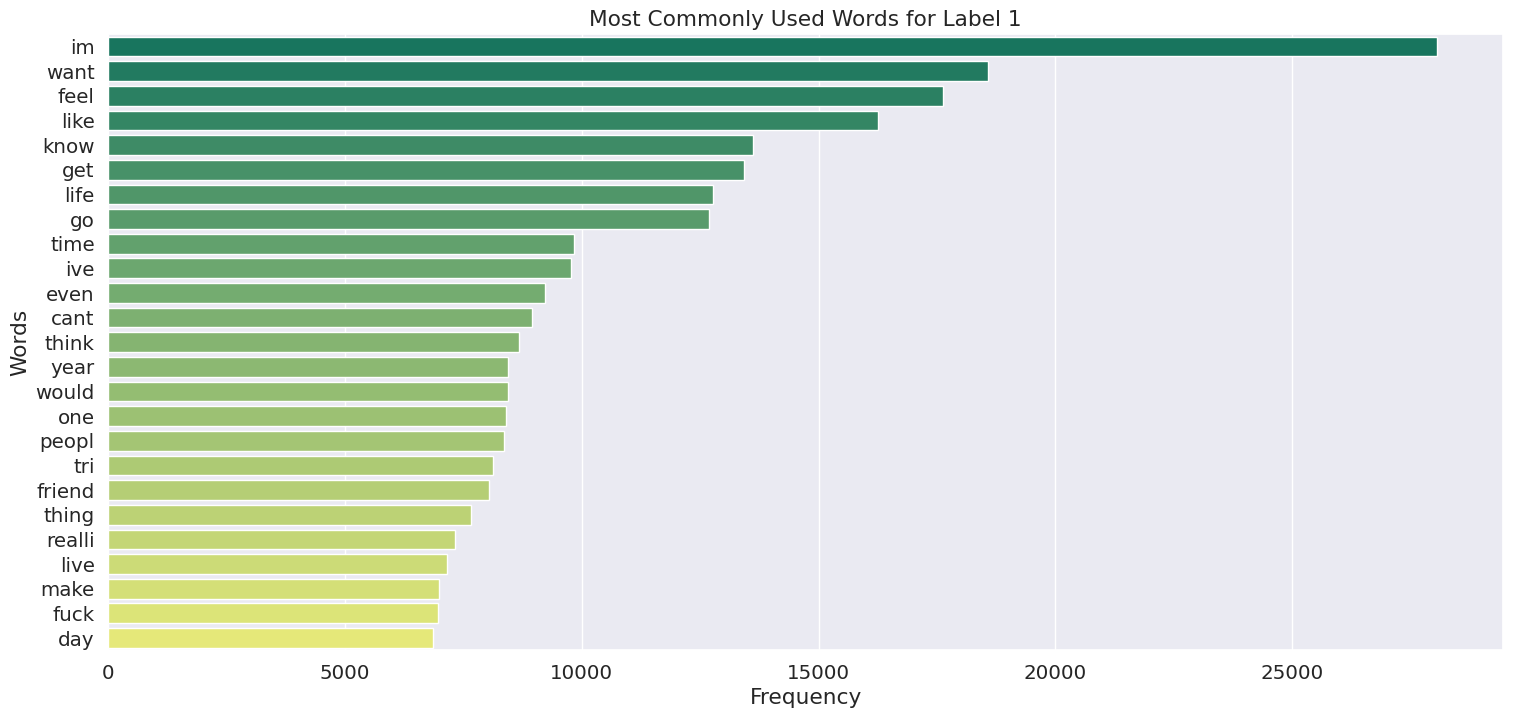

In [13]:
all_spam_words = []
for sentence in data[data['label'] == 1]['text'].to_list():
    for word in sentence.split():
        all_spam_words.append(word)

df = pd.DataFrame(Counter(all_spam_words).most_common(25), columns= ['Word', 'Frequency'])

sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(18,8))
sns.barplot(y = df['Word'], x= df['Frequency'], palette= 'summer')
plt.title("Most Commonly Used Words for Label 1")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

In [14]:
def create_barplot(most_common_bigrams):
    bigrams, counts = zip(*most_common_bigrams)
    bigram_labels = [f"{bigram[0]} {bigram[1]}" for bigram in bigrams]
    df = pd.DataFrame({'Bigram': bigram_labels, 'Count': counts})

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Count', y='Bigram', data=df, palette='viridis')
    plt.xlabel('Counts')
    plt.title(f'Top 20 Most Common Bigrams')
    plt.show()
def plot_top_ngrams_barchart(corpus):
    corpus = [sentence.split() for sentence in corpus]
    word_list=[word for sentence in corpus for word in sentence]

    ngrams = [(word_list[i], word_list[i+1]) for i in range(len(word_list)-1)]
    ngram_counts = Counter(ngrams)

    most_common_bigrams = ngram_counts.most_common(20)
    create_barplot(most_common_bigrams)


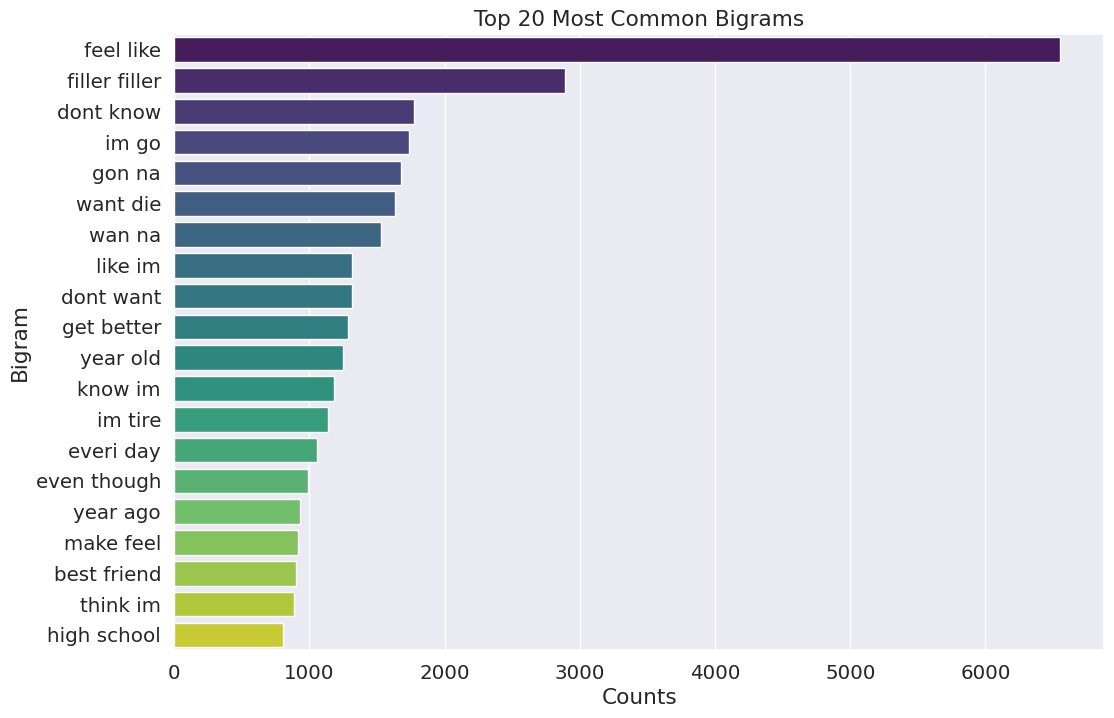

In [15]:
plot_top_ngrams_barchart(data['text'])

There are 54825 unique words


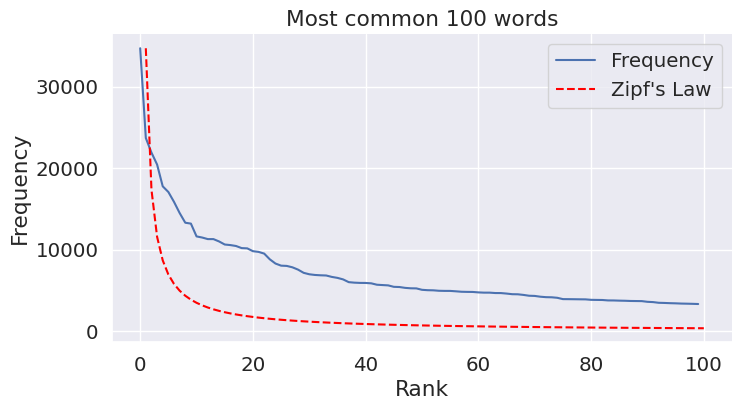

In [16]:
all_spam_words = []
for sentence in data['text'].to_list():
    for word in sentence.split():
        all_spam_words.append(word)
unique_words = len(set(all_spam_words))
print("There are", unique_words, "unique words")
df = pd.DataFrame(Counter(all_spam_words).most_common(100), columns= ['Word', 'Frequency'])

from matplotlib import pyplot as plt
df['Frequency'].plot(kind='line', figsize=(8, 4), title='Most common 100 words')
plt.gca().spines[['top', 'right']].set_visible(False) #Hide the top and right spines of the plot for a cleaner look.
ranks = range(1, len(df) + 1)
zipf_frequencies = [df['Frequency'].iloc[0] / r for r in ranks]

# Add Zipf's law to the plot
plt.plot(ranks, zipf_frequencies, linestyle='--', color='red', label="Zipf's Law")
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.legend()

### Transform the dataset into an acceptable input


In [17]:
from torch.utils.data import Dataset
import torch

class CustomDataset(Dataset):
    def __init__(self, data_list):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        item = self.data_list[idx]
        input_ids = torch.tensor(item['input_ids'])
        label = torch.tensor(item['label'])

        if 'attention_mask' in item:
          attention_mask = torch.tensor(item['attention_mask'])
          text = item['text']
          return {
              'input_ids': input_ids,
              'attention_mask': attention_mask,
              'label': label,
              'text': text
          }
        return{
            'input_ids': input_ids,
            'label':label
        }

### Tf-idf with Naive Bayes, SVD and Random Forest

In [44]:
X = data["text"]
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 101, stratify = y)

TfidfVectorizer combines Count Vectorizer and TfIdf Transformer: TfIdfVectorizer performs both term frequency (TF) counting and the IDF (inverse document frequency) transformation in a single step. It essentially combines the functionalities of CountVectorizer and TfIdfTransformer without the need of a term-document matrix

In [19]:
tfidf = TfidfVectorizer(max_features= 2500, min_df= 2)
X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

In [20]:
#@title Naive Bayes
def train_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)

    print(f'Accuracy of the model: {accuracy}')
    print(f'Precision Score of the model: {precision}')
    print(f'Recall Score of the model: {recall}')

    # sns.set_context('notebook', font_scale= 1.3)
    # fig, ax = plt.subplots(1, 2, figsize = (25,  8))
    # ax1 = plot_confusion_matrix(y_test, y_pred, ax= ax[0], cmap= 'YlGnBu')
    # ax2 = plot_roc(y_test, y_prob, ax= ax[1], plot_macro= False, plot_micro= False, cmap= 'summer')
nb = MultinomialNB()
train_model(nb)

Accuracy of the model: 0.888
Precision Score of the model: 0.839
Recall Score of the model: 0.957


In [ ]:
nursing_data = pd.read_csv('depression_data.csv')
nursing_data = preprocessor.apply(nursing_data, 'content')
nursing_data = nursing_data['content']

In [ ]:
nursing_data_idf = tfidf.transform(nursing_data).toarray()

In [ ]:
predictions = nb.predict(nursing_data_idf)

In [ ]:
filtered_df = nursing_data[predictions == 1]
filtered_df.to_csv('prova.csv')

In [ ]:
sum(predictions)/len(predictions)

0.9419134396355353

In [21]:
#@title Random Forest
rf = RandomForestClassifier(n_estimators= 300)
train_model(rf)

KeyboardInterrupt: 

In [ ]:
#@title SVD on Tf-idf
def train_SVD_model(n_dims):
  # Apply SVD decomposition to the tfidf matrix
  # Truncate matrix U of SVD
  svd = TruncatedSVD(n_components=n_dims)
  X_train_SVD = svd.fit_transform(X_train)
  X_test_SVD = svd.transform(X_test)
  classifier = LogisticRegression()
  classifier.fit(X_train_SVD, y_train)
  y_pred = classifier.predict(X_test_SVD)
  y_prob = classifier.predict_proba(X_test_SVD)
  accuracy = round(accuracy_score(y_test, y_pred), 3)
  precision = round(precision_score(y_test, y_pred), 3)
  recall = round(recall_score(y_test, y_pred), 3)

  print(f'Accuracy of the model: {accuracy}')
  print(f'Precision Score of the model: {precision}')
  print(f'Recall Score of the model: {recall}')
train_SVD_model(1000)
#Negative values in data passed to MultinomialNB (input X)
#Multinomial Naive Bayes (MultinomialNB) is a variant of the Naive Bayes classifier that is particularly suited for classification with discrete feature vectors, such as word counts in text classification. It is based on the multinomial distribution, which models the probability of observing counts of various outcomes in a fixed number of trials

Accuracy of the model: 0.915
Precision Score of the model: 0.923
Recall Score of the model: 0.902


### Word Embeddings

In [45]:
from multiprocessing import cpu_count
X = [sentence.split() for sentence in X]
cpu = cpu_count()
print('The virtual instance has {} cpus, that will be used to train the word2vec model'.format(cpu))

print("Training the W2V ...")
w2v = Word2Vec(X, vector_size=100, window=5, min_count=3, workers=cpu)
w2v.train(X, total_examples=len(X), epochs=5)
w2v_wv = w2v.wv

The virtual instance has 2 cpus, that will be used to train the word2vec model
Training the W2V ...


In [28]:
from sklearn.manifold import TSNE

def reduce_dimensions(model):
    num_components = 2  # numero di dimensioni da mantenere in seguito alla compressione

    # estraiamo il vocabolario dal modello e i vettori in modo da associarli nel grafico
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    # applichiamo TSNE
    tsne = TSNE(n_components=num_components, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


def plot_embeddings(x_vals, y_vals, labels):
    import plotly.graph_objs as go
    fig = go.Figure()
    trace = go.Scatter(x=x_vals, y=y_vals, mode='markers', text=labels)
    fig.add_trace(trace)
    fig.update_layout(title="Word2Vec - Visualizzazione embedding con TSNE")
    return fig
x_vals, y_vals, labels = reduce_dimensions(w2v)
plot_embeddings(x_vals, y_vals, labels)

In [30]:
def closest_to(w, n=10):
    if w in w2v_wv:
      closest_ws =[w[0] for w in w2v_wv.most_similar(w, topn=n)]
      print("the closest {}, words to \"{}\" "
      "are: \n {}".format(n, w, '"'+'",\n then "'.join(closest_ws)+'"'))
    else:
      print(w, " could not be found in the vocabulary")
closest_to('sober')
closest_to('bad')

the closest 10, words to "sober" are: 
 "relap",
 then "alcohol",
 then "drank",
 then "bing",
 then "drink",
 then "weed",
 then "selfharm",
 then "addict",
 then "drug",
 then "recov"
the closest 10, words to "bad" are: 
 "good",
 then "aw",
 then "terribl",
 then "horribl",
 then "like",
 then "worst",
 then "wor",
 then "guilti",
 then "badli",
 then "fault"


In [31]:
w2v.wv.doesnt_match(['scissor', 'knot', 'bestfriend'])

'bestfriend'

In [35]:
#result = pretrained_vectors.most_similar(positive=['woman', 'king'], negative=['man']) --> king-man+woman
#prozac:insomnia=?:anxiety --> prozac - insomnia + anxiety --> another medicine?
result = w2v_wv.most_similar(positive=['cri', 'happi'], negative=['bad'], topn=1)
print("Most similar word:", result)
result = w2v_wv.most_similar(positive=['prozac', 'anxieti'], negative=['insomnia'], topn=1)
print("Most similar word:", result)

Most similar word: [('smile', 0.5299732089042664)]
Most similar word: [('antidepress', 0.6517893075942993)]


### Models trained from scratch


####Tokenization

In [37]:
with open("sentences.txt", "w", encoding="utf-8") as f:
    for sentence in X_train:
        f.write(sentence + "\n")

In [38]:
vocab_size=10000
tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))
tokenizer.decoder = decoders.WordPiece() # responsible for decoding token IDs back into human-readable tokens or text

# we can set various special tokens useful for handling specific cases if needed.
trainer = WordPieceTrainer(vocab_size=vocab_size,
                     special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"])

from tokenizers.pre_tokenizers import Whitespace
from tokenizers.normalizers import Lowercase

#before tokenization we lowercase all words
tokenizer.normalizer = Lowercase()
#This pre-tokenizer simply splits using the following regex: \w+|[^\w\s]+
tokenizer.pre_tokenizer = Whitespace()

train_file = "./sentences.txt"
files = [train_file]
tokenizer.train(files, trainer)

saved_tokenizer = "./tokenizer-recipe.json"
tokenizer.save(saved_tokenizer)

In [39]:
def set_seed(seed):
    random.seed(seed)
    numpy.random.seed(seed)
    torch.random.manual_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed = 0
set_seed(seed)
 #-----------------------------

tokenizer = Tokenizer.from_file(saved_tokenizer)

# Associate padding to its special token's id
pad_id = tokenizer.token_to_id("[PAD]")
print("PAD ID: "+str(pad_id))
tokenizer.enable_padding(pad_id=pad_id, pad_token="[PAD]")

fast_tokenizer = PreTrainedTokenizerFast(tokenizer_object=tokenizer)
fast_tokenizer.model_max_length = 200

vocab_size = len(fast_tokenizer)
print("VOCABULARY SIZE: "+str(vocab_size))
padding_idx = fast_tokenizer.pad_token_id
print("CHECK PADDING IDX: "+str(padding_idx))

PAD ID: 0
VOCABULARY SIZE: 10000
CHECK PADDING IDX: 0


In [40]:
output_example = tokenizer.encode("i love math and feeling good, antidepression. Lovelife [PAD]")
print(output_example.tokens)
print(output_example.ids)
print(tokenizer.decode(output_example.ids))

['i', 'love', 'math', 'and', 'feeling', 'good', '[UNK]', 'antidepress', '##ion', '[UNK]', 'love', '##lif', '##e', '[PAD]']
[13, 251, 2114, 2878, 7822, 239, 1, 2295, 200, 1, 251, 2136, 42, 0]
i love math and feeling good antidepression lovelife


#### LSTM

In [48]:
dataset = []

def tokenize_data(example):
    return fast_tokenizer(example, truncation=True)

for sentence in X_train:
    dataset.append(tokenize_data(sentence).input_ids)
padded_sequences = pad_sequences(dataset, maxlen=fast_tokenizer.model_max_length, padding="post")

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=512, input_length = fast_tokenizer.model_max_length))
model.add(Bidirectional(LSTM(512, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(padded_sequences, y_train, epochs=10, batch_size=32, validation_split=0.2)
model.save('3_epoch_BiLSTM.h5')

Epoch 1/10


In [ ]:
dataset = []

def tokenize_data(example):
    return fast_tokenizer(example, truncation=True)

for sentence in X_test:
    dataset.append(tokenize_data(sentence).input_ids)
padded_sequences = pad_sequences(dataset, maxlen=fast_tokenizer.model_max_length, padding="post")
predictions = model.predict(padded_sequences)
print(predictions)

####LSTM with Word2Vec

In [41]:
#this is the same as padded_sequences with tokens instead of ids
tokens_corpus = []
max_len = 200
for sentence in X_train:
    tokens = tokenizer.encode(sentence).tokens
    for i in range(max_len - len(tokens)):
        tokens.append('[PAD]')
    tokens_corpus.append(tokens)

In [49]:
w2v = Word2Vec(tokens_corpus, vector_size=100, window=5, min_count=3)
w2v.train(tokens_corpus, total_examples=len(tokens_corpus), epochs=5)
w2v_wv = w2v.wv

In [50]:
embedding_matrix = np.zeros((len(tokenizer.get_vocab().keys()), 100))
for word, i in tokenizer.get_vocab().items():
    if word in w2v_wv:
        embedding_matrix[i] = w2v_wv[word]

In [51]:
model = Sequential()
model.add(Embedding(len(tokenizer.get_vocab().keys()), 100, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Allenamento del modello
labels = np.array([0, 1])  # Esempio etichette di classe
model.fit(padded_sequences, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=2)


Epoch 1/10
560/560 - 10s - loss: 0.6400 - accuracy: 0.6034 - val_loss: 0.6463 - val_accuracy: 0.5906 - 10s/epoch - 18ms/step
Epoch 2/10
560/560 - 5s - loss: 0.4233 - accuracy: 0.8169 - val_loss: 0.2849 - val_accuracy: 0.8957 - 5s/epoch - 9ms/step
Epoch 3/10
560/560 - 6s - loss: 0.2480 - accuracy: 0.9094 - val_loss: 0.2320 - val_accuracy: 0.9145 - 6s/epoch - 11ms/step
Epoch 4/10
560/560 - 5s - loss: 0.2144 - accuracy: 0.9222 - val_loss: 0.2103 - val_accuracy: 0.9200 - 5s/epoch - 9ms/step
Epoch 5/10
560/560 - 5s - loss: 0.1976 - accuracy: 0.9285 - val_loss: 0.2027 - val_accuracy: 0.9229 - 5s/epoch - 9ms/step
Epoch 6/10
560/560 - 6s - loss: 0.1812 - accuracy: 0.9350 - val_loss: 0.1956 - val_accuracy: 0.9223 - 6s/epoch - 10ms/step
Epoch 7/10
560/560 - 5s - loss: 0.1689 - accuracy: 0.9391 - val_loss: 0.1795 - val_accuracy: 0.9287 - 5s/epoch - 9ms/step
Epoch 8/10
560/560 - 6s - loss: 0.1564 - accuracy: 0.9440 - val_loss: 0.1749 - val_accuracy: 0.9312 - 6s/epoch - 10ms/step
Epoch 9/10
560/560

#### Encoder-Decoder transformer

In [53]:
nb_epoch=1 # it should be more
batch_size = 32
learning_rate = 1e-4
saving_model_path= "./my_trf_ep"

In [56]:
X_test, X_dev, y_test, y_dev = train_test_split(X_test, y_test, test_size= 0.2, random_state= 101)
def tokenize_function(sentence, i):
    result = fast_tokenizer(sentence, padding=True, truncation=True)
    label = [padding_idx, y_train[i]+1]
    return {'input_ids': result['input_ids'], 'label': label}

tokenized_X_train=[]
for i, sentence in enumerate(X_train):
    tokenized_X_train.append({**tokenize_function(sentence, i)})
tokenized_X_dev = []
for i, sentence in enumerate(X_dev):
    tokenized_X_dev.append({**tokenize_function(sentence, i)})

custom_X_train = CustomDataset(tokenized_X_train)
custom_X_dev = CustomDataset(tokenized_X_dev)

In [ ]:
datacollator = DataCollatorForSeq2Seq(tokenizer=fast_tokenizer)
dataloader_train = DataLoader(custom_X_train, batch_size=batch_size, drop_last=False, shuffle=True, collate_fn=datacollator)

In [ ]:
from x_transformers import XTransformer

model_trf = XTransformer(
    dim = 512,
    enc_num_tokens = vocab_size,
    enc_depth = 2,
    enc_heads = 8,
    enc_max_seq_len = fast_tokenizer.model_max_length,
    dec_num_tokens = 3, #we only have three tokens vocabulary: 0, 1 and 2
    dec_depth = 2,
    dec_heads = 8,
    dec_max_seq_len = 2, #we only have pad and label
    pad_value=padding_idx,
)
#print(model_trf)
#model_trf.cuda()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model_trf.parameters(), lr=learning_rate)

XTransformer(
  (encoder): TransformerWrapper(
    (token_emb): TokenEmbedding(
      (emb): Embedding(30000, 512)
    )
    (pos_emb): AbsolutePositionalEmbedding(
      (emb): Embedding(200, 512)
    )
    (post_emb_norm): Identity()
    (emb_dropout): Dropout(p=0, inplace=False)
    (project_emb): Identity()
    (attn_layers): Encoder(
      (layers): ModuleList(
        (0): ModuleList(
          (0): ModuleList(
            (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (1-2): 2 x None
          )
          (1): Attention(
            (to_q): Linear(in_features=512, out_features=512, bias=False)
            (to_k): Linear(in_features=512, out_features=512, bias=False)
            (to_v): Linear(in_features=512, out_features=512, bias=False)
            (attend): Attend(
              (attn_dropout): Dropout(p=0.0, inplace=False)
            )
            (to_out): Linear(in_features=512, out_features=512, bias=False)
          )
          (2): Residual()
  

In [ ]:
dataloader_dev = DataLoader(custom_X_dev, batch_size=1, drop_last=False, shuffle=False)

def evaluate_model(model_trf, dataloader_evaluate):
    model_trf.eval()
    GENERATE_LENGTH=1
    total = 0
    correct =0
    for item in tqdm(dataloader_evaluate, disable=True):
        input_ids_src = item['input_ids'].to('cuda')
        #we use the padding to start the generation, and it has a 0 id
        #start_tokens = (torch.zeros((1, 1)) * 1).long().cuda()
        start_tokens = torch.zeros((1)).long().cuda()

        sample = model_trf.generate(input_ids_src, start_tokens, GENERATE_LENGTH)
        output = sample.tolist()
        #print(output)
        output = output[0]
        #print(output)
        input_ids_tgt = item['labels']
        #print(input_ids_tgt)
        label = input_ids_tgt[0,1].item()
        #label
        if output == label:
          correct+=1
        total+=1

    print("done with the evaluation")
    print("total instances: "+str(total))
    print("correct instances: "+str(correct))
    accuracy = correct/total
    print(accuracy)
    model_trf.train()
    return accuracy


In [ ]:
PRINT_EVERY=100
best_dev_accuracy = 0.0
i = 0
for epoch in range(nb_epoch):
    print("EPOCH "+str(epoch))
    for item in tqdm(dataloader_train): #, disable=True):
        input_ids_src = item['input_ids']
        input_ids_tgt = item['labels']

        optimizer.zero_grad()
        #print(input_ids_src)
        #print(input_ids_tgt)
        #print(input_ids_src.shape)
        #print(input_ids_tgt.shape)
        loss = model_trf(input_ids_src, input_ids_tgt)
        loss.backward()
        optimizer.step()
        if i % PRINT_EVERY ==0:
            print(loss)
        i+=1
    #save best checkpoint on dev set
    accuracy_dev = evaluate_model(model_trf, dataloader_dev)
    if accuracy_dev > best_dev_accuracy:
        best_dev_accuracy = accuracy_dev
        torch.save(model_trf.state_dict(), saving_model_path + "_bestOnDev.pt")

EPOCH 0




  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 1/700 [00:14<2:49:37, 14.56s/it]

tensor(1.8075, grad_fn=<NllLoss2DBackward0>)




  0%|          | 2/700 [00:25<2:24:10, 12.39s/it]

  0%|          | 3/700 [00:38<2:27:39, 12.71s/it]


KeyboardInterrupt: 

### Pre-trained model

In [ ]:
def tokenize_function(tokenizer, sentence):
    return tokenizer(sentence, padding=True, truncation=True)

def tokenized_dataset(tokenizer, x_train, x_dev, y_train, y_dev):
  tokenized_X_train=[]
  for i, sentence in enumerate(x_train):
      tokenized_X_train.append({**tokenize_function(sentence), **{"label": int(y_train[i]), "text": sentence}})

  tokenized_X_dev = []
  for i, sentence in enumerate(x_dev):
      tokenized_X_dev.append({**tokenize_function(sentence), **{"label": int(y_dev[i]), "text": sentence}})
  return CustomDataset(tokenized_X_train), CustomDataset(tokenized_X_dev)

In [ ]:
#model_name = "distilbert/distilbert-base-cased"
model_name = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
custom_X_train, custom_X_dev = tokenized_dataset(tokenizer, X_train, X_dev, y_train, y_dev)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
num_labels = 2
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}
#Models loaded with AutoModelForSequenceClassification are pre-configured for sequence classification tasks. They include a classification head (typically a linear layer) on top of the transformer encoder layers
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, id2label=id2label, label2id=label2id)

distilbert/distilbert-base-uncased


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def get_accuracy(pred):
    preds = pred.predictions.argmax(axis=-1)
    labels = pred.label_ids
    accuracy = accuracy_score(labels, preds)
    return {'accuracy': accuracy}

In [ ]:
batch_size = 32
epochs = 5
logging_steps = len(X_train) // batch_size
model_name_output_dir = model_name.replace("/", "-") + "-finetuned"
training_args = TrainingArguments(
            output_dir=model_name_output_dir,
            num_train_epochs=epochs,
            learning_rate=1e-4,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            weight_decay=0.01,
            evaluation_strategy="epoch",
            disable_tqdm=False,
            logging_steps=logging_steps,
            log_level="error",
            optim="adamw_torch"
)


In [ ]:
trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=get_accuracy,
                  train_dataset=custom_X_train,
                  eval_dataset=custom_X_dev,
                  tokenizer=tokenizer)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.233800,0.223678,0.932584
2,0.086600,0.173722,0.943820
3,0.035000,0.378618,0.943820
4,0.020000,0.195615,0.943820
5,0.007000,0.216673,0.943820


TrainOutput(global_step=280, training_loss=0.07514572793152183, metrics={'train_runtime': 112.4856, 'train_samples_per_second': 78.81, 'train_steps_per_second': 2.489, 'total_flos': 886736249152488.0, 'train_loss': 0.07514572793152183, 'epoch': 5.0})

In [ ]:
import os

bert_save_path = '/content/drive/MyDrive/Colab Notebooks/NLP_project/models/bert'
os.makedirs(bert_save_path, exist_ok=True)

model.save_pretrained(f"{bert_save_path}/fine_tuned_bert")
tokenizer.save_pretrained(f"{bert_save_path}/bert_tokenizer")


('/content/drive/MyDrive/Colab Notebooks/NLP_project/models/bert/bert_tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/NLP_project/models/bert/bert_tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/NLP_project/models/bert/bert_tokenizer/vocab.txt',
 '/content/drive/MyDrive/Colab Notebooks/NLP_project/models/bert/bert_tokenizer/added_tokens.json',
 '/content/drive/MyDrive/Colab Notebooks/NLP_project/models/bert/bert_tokenizer/tokenizer.json')

In [ ]:
def load_finetuned_bert():
  model_path = '/content/drive/MyDrive/Colab Notebooks/NLP_project/models/bert/fine_tuned_bert'
  tokenizer_path = '/content/drive/MyDrive/Colab Notebooks/NLP_project/models/bert/bert_tokenizer'

  model = AutoModelForSequenceClassification.from_pretrained(model_path)
  tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

  return model, tokenizer


In [ ]:
model, tokenizer = load_finetuned_bert()

In [ ]:
import gc
def clear_gpu_memory():
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification

model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name, pad_token = tokenizer.eos_token)
custom_X_train, custom_X_dev = tokenized_dataset(tokenizer, X_train, X_dev, y_train, y_dev)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:
model = GPT2ForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.config.pad_token_id = tokenizer.pad_token_id
output_dir = model_name_output_dir = model_name.replace("/", "-") + "-finetuned"
#output_dir = "/content/drive/MyDrive/Colab Notebooks/NLP_project/models/gpt2/results"
#os.makedirs(output_dir, exist_ok=True)

training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=4,  # Reduce the batch size
    per_device_eval_batch_size=4,   # Reduce the batch size for evaluation as well
    num_train_epochs=2,
    weight_decay=0.01,
    gradient_accumulation_steps=2,  # Accumulate gradients over 2 steps
    fp16=True,  # Enable mixed precision training
)

def compute_metrics(eval_pred):
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=custom_X_train,
    eval_dataset=custom_X_dev,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Clear GPU memory before training
clear_gpu_memory()

trainer.train()

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`

In [ ]:
clear_gpu_memory()

In [ ]:
# Save the model
model_save_path = '/fine_tuned_gpt2'
#os.makedirs(model_save_path, exist_ok=True)

model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

# Clear GPU memory after saving
clear_gpu_memory()

In [ ]:
from transformers import AutoModelForSequenceClassification
model_name = 'google-t5/t5-small'
num_labels = 2
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}
#Models loaded with AutoModelForSequenceClassification are pre-configured for sequence classification tasks. They include a classification head (typically a linear layer) on top of the transformer encoder layers
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, id2label=id2label, label2id=label2id)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at google-t5/t5-small and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import AutoTokenizer

print(model_name)
tokenizer = AutoTokenizer.from_pretrained('google-t5/t5-small')
custom_X_train, custom_X_dev = tokenized_dataset(tokenizer, X_train, X_dev, y_train, y_dev)

google-t5/t5-small


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [ ]:
from transformers import TrainingArguments

epochs=1
batch_size = 8
logging_steps = len(X_train) // batch_size
model_name_output_dir = model_name.replace("/", "-")+"-finetuned-imdb"
training_args = TrainingArguments(output_dir=model_name_output_dir,
                                  num_train_epochs=epochs,
                                  learning_rate=1e-4,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  log_level="error",
                                  optim='adamw_torch'
                                  )

ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`

In [ ]:
def get_accuracy(preds):
  preds_preds = preds.predictions[0] if isinstance(preds.predictions, tuple) else preds.predictions
  predictions = preds_preds.argmax(axis=-1)
  labels = preds.label_ids
  accuracy = accuracy_score(preds.label_ids, preds_preds.argmax(axis=-1))
  return {'accuracy': accuracy}

In [ ]:
trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=get_accuracy,
                  train_dataset=custom_X_train,
                  eval_dataset=custom_X_dev,
                  tokenizer=tokenizer)
trainer.train()

  0%|          | 6/2798 [00:12<59:45,  1.28s/it]  

KeyboardInterrupt: 